In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../../Lessons/Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# imports and configuration
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchinfo import summary

import torchvision.transforms.v2 as transforms
from torchvision.datasets import FashionMNIST

from introdl.utils import get_device, load_results, load_model, summarizer, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, vis_feature_maps, vis_feature_maps_widget, interactive_mnist_prediction
from introdl.visul import evaluate_classifier, create_image_grid

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

device = get_device() # doing locally with cuda

MODELS_PATH=.
DATA_PATH=.
TORCH_HOME=.
HF_HOME=.


# Homework 3 - Better Training

In this assignment you will build a deeper CNN model to improve the classification performance on the FashionMNIST dataset.  Deeper models can be more difficult to train so you'll employ some of the techniques from Lesson 3 to improve the training.  You'll also use data augmentation to improve the performance of the model while reducing overfitting.  Along the way you'll see how to downsample a dataset to make for more efficient experimentaton.

## Build the model (5 pts)

Implement a PyTorch model of class `nn.module` to reproduce a model with this structure
```
====================================================================================================
Layer (type (var_name))                  Input Shape          Output Shape         Param #
====================================================================================================
FashionMNISTModel (FashionMNISTModel)    [64, 1, 28, 28]      [64, 10]             --
├─Sequential (block1)                    [64, 1, 28, 28]      [64, 32, 14, 14]     --
│    └─Sequential (0)                    [64, 1, 28, 28]      [64, 32, 28, 28]     --
│    │    └─Conv2d (0)                   [64, 1, 28, 28]      [64, 32, 28, 28]     320
│    │    └─ReLU (1)                     [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    │    └─Conv2d (2)                   [64, 32, 28, 28]     [64, 32, 28, 28]     9,248
│    │    └─ReLU (3)                     [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    │    └─Conv2d (4)                   [64, 32, 28, 28]     [64, 32, 28, 28]     9,248
│    │    └─ReLU (5)                     [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─MaxPool2d (1)                     [64, 32, 28, 28]     [64, 32, 14, 14]     --
├─Sequential (block2)                    [64, 32, 14, 14]     [64, 64, 7, 7]       --
│    └─Sequential (0)                    [64, 32, 14, 14]     [64, 64, 14, 14]     --
│    │    └─Conv2d (0)                   [64, 32, 14, 14]     [64, 64, 14, 14]     18,496
│    │    └─ReLU (1)                     [64, 64, 14, 14]     [64, 64, 14, 14]     --
│    │    └─Conv2d (2)                   [64, 64, 14, 14]     [64, 64, 14, 14]     36,928
│    │    └─ReLU (3)                     [64, 64, 14, 14]     [64, 64, 14, 14]     --
│    │    └─Conv2d (4)                   [64, 64, 14, 14]     [64, 64, 14, 14]     36,928
│    │    └─ReLU (5)                     [64, 64, 14, 14]     [64, 64, 14, 14]     --
│    └─MaxPool2d (1)                     [64, 64, 14, 14]     [64, 64, 7, 7]       --
├─Sequential (block3)                    [64, 64, 7, 7]       [64, 128, 7, 7]      --
│    └─Conv2d (0)                        [64, 64, 7, 7]       [64, 128, 7, 7]      73,856
│    └─ReLU (1)                          [64, 128, 7, 7]      [64, 128, 7, 7]      --
│    └─Conv2d (2)                        [64, 128, 7, 7]      [64, 128, 7, 7]      147,584
│    └─ReLU (3)                          [64, 128, 7, 7]      [64, 128, 7, 7]      --
│    └─Conv2d (4)                        [64, 128, 7, 7]      [64, 128, 7, 7]      147,584
│    └─ReLU (5)                          [64, 128, 7, 7]      [64, 128, 7, 7]      --
├─Linear (fc)                            [64, 6272]           [64, 10]             62,730
====================================================================================================
Total params: 542,922
Trainable params: 542,922
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.26
====================================================================================================
Input size (MB): 0.20
Forward/backward pass size (MB): 67.44
Params size (MB): 2.17
Estimated Total Size (MB): 69.81
====================================================================================================
```
You can, of course, type out all of the individual layers or you can build the repeating structure programatically (we'll see more of that next week - your book does this in Chapter 6 on page 209).  Make a model summary to check your work.


In [3]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
    if out_filters is None:
        out_filters = in_filters
    padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.ReLU()
    )
        
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            cnn_layer(1, 32),
            cnn_layer(32),
            cnn_layer(32),
        )
        self.block2 = nn.Sequential(
            cnn_layer(32, 64),
            cnn_layer(64),
            cnn_layer(64),
        )
        self.block3 = nn.Sequential(
            cnn_layer(64, 128),
            cnn_layer(128),
            cnn_layer(128)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128*7*7, 10)
        
    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = self.block3(x)
        x = x.view(-1, 128*7*7) #flatten
        x = self.fc(x)
        return x

In [4]:
model = CNN_model()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
CNN_model (CNN_model)                    [64, 1, 28, 28]      [64, 10]             --
├─Sequential (block1)                    [64, 1, 28, 28]      [64, 32, 28, 28]     --
│    └─Sequential (0)                    [64, 1, 28, 28]      [64, 32, 28, 28]     --
│    │    └─Conv2d (0)                   [64, 1, 28, 28]      [64, 32, 28, 28]     320
│    │    └─ReLU (1)                     [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─Sequential (1)                    [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    │    └─Conv2d (0)                   [64, 32, 28, 28]     [64, 32, 28, 28]     9,248
│    │    └─ReLU (1)                     [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─Sequential (2)                    [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    │    └─Conv2d (0)                   [64, 32, 28, 28]     [64, 32, 28, 28]     9,248
│    │    └─ReLU (1)                     [

## Setup the data (5 pts)

Load the FashionMNIST dataset.  Normalize with mean 0.2860 and standard deviation 0.3530.  Downsample the train dataset to 10% of its original size to make experimentation quick.  You can use this code for downsampling:

```python
from torch.utils.data import Subset
np.random.seed(42)  # use this seed for reproducibility
subset_indices = np.random.choice(len(train_dataset), size=int(0.1 * len(train_dataset)), replace=False)
train_dataset = Subset(train_dataset, subset_indices)
```

Use the FashionMNIST test dataset for your `valid_dataset`.

For the DataLoaders try batch size 64 to start.



In [5]:
#### Solution
# Transformations
mean = (0.2860,)
std = (0.3530,)
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean,std),
])

# load data
train_dataset = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=DATA_PATH, train=False, download=True, transform=transform)

# downsample train data
np.random.seed(42)
subset_indicies = np.random.choice(len(train_dataset), size=int(0.1 * len(train_dataset)), replace=False)
train_dataset = Subset(train_dataset, subset_indicies)

# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



100%|██████████| 26.4M/26.4M [00:02<00:00, 9.43MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 183kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 1.33MB/s]


## Training with SGD (5 pts)

Train your model with Stochastic Gradient Descent.  Track the accuracy metric.  You'll likely need to increase both the learning rate and the number of epochs to see the validation accuracy plateau.  

Make sure to instantiate a fresh model to see complete training results. (Although you could resume from a checkpoint as part of your experimentation.)

In [8]:
#### Solution
model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.SGD(model.parameters(), lr=0.05)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_SGD.pt'
epochs = 20

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_SGD = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Load the checkpoint file and make graphs showing the training and validation losses and accuracies.

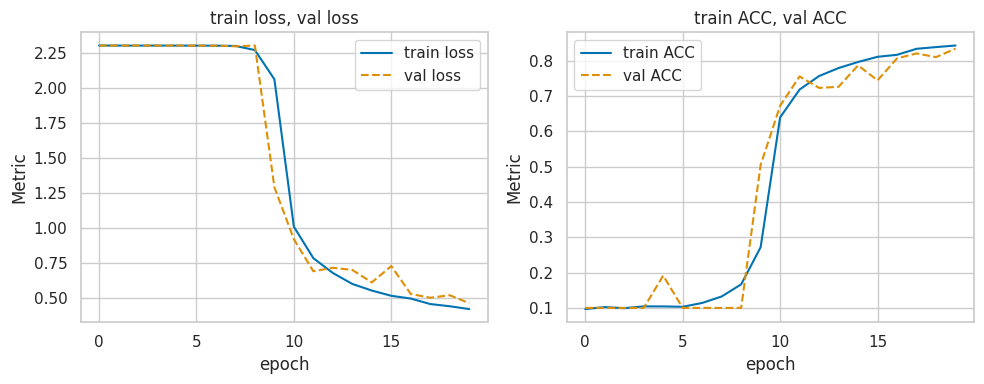

In [9]:
#### Solution
plot_training_metrics(results_FashionMNIST_SGD,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])

## Training with AdamW (5 pts)

Now repeat the previous training using AdamW.  You should be able to use the default learning rate of 0.001 and fewer epochs.

In [10]:
#### Solution
model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW.pt'
epochs = 20 #ran for 20 for comparison graph

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Load the checkpoint file and make graphs showing the training and validation losses and accuracies.

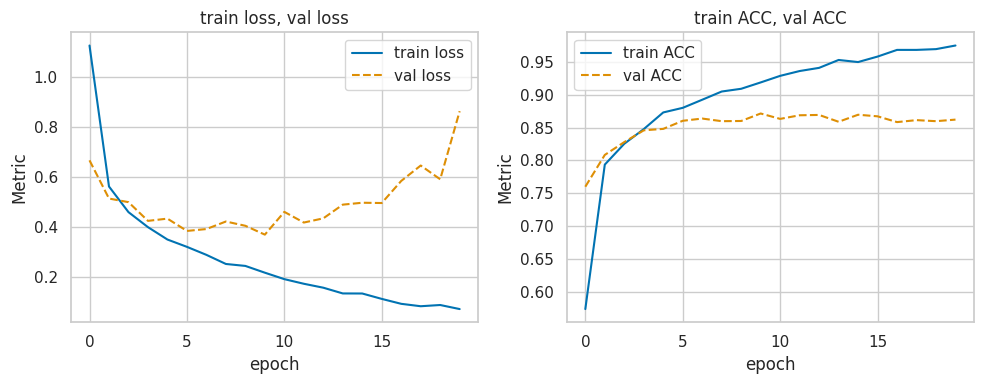

In [11]:
#### Solution
plot_training_metrics(results_FashionMNIST_AdamW,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])


#### Compare SGD and AdamW Training Performance

Make plots of validation loss and accuracy for both SGD and AdamW.

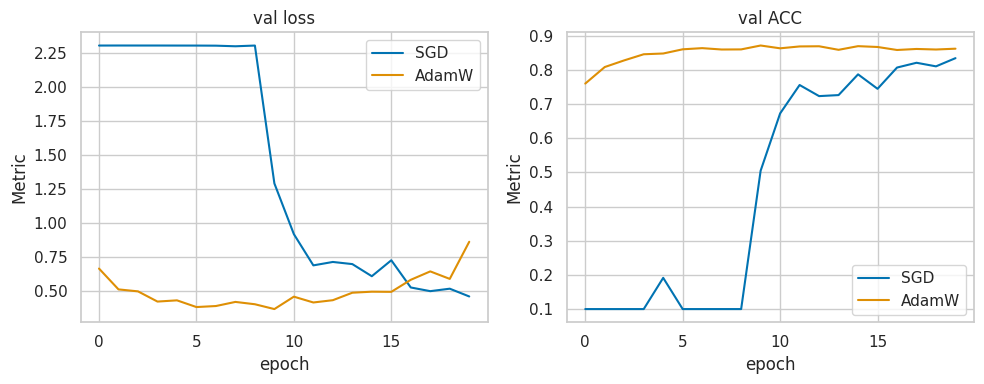

In [12]:
#### Solution
SGD = load_results(MODELS_PATH / 'HW03_FashionMNIST_SGD.pt')
AdamW = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW.pt')

plot_training_metrics([SGD, AdamW], [['val loss'], ['val ACC']],df_labels=['SGD','AdamW'])


## Data Augmentation (5 pts)

Now use data augmentation.  Build a transform_train pipleline that includes
* Random horizontal flips
* Random crops of size 28, padding = 4
* Random rotations up to 10 degrees

Use the same seed to downsample the train_dataset to 10% of its size.

In the next cell, set up the data and augmentation transforms (don't augment the validation data).  Build the DataLoaders.

In [ ]:
#### Solution

# Transformations
mean = (0.2860,)
std = (0.3530,)
transform_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomRotation(10),
    transforms.Normalize(mean,std),
    transforms.ToPureTensor(),
])

# load data
train_dataset_aug = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform_aug)
test_dataset_aug = FashionMNIST(root=DATA_PATH, train=False, download=True, transform=transform_aug)

# downsample train data
np.random.seed(42)
subset_indicies = np.random.choice(len(train_dataset_aug), size=int(0.1 * len(train_dataset_aug)), replace=False)
train_dataset_aug = Subset(train_dataset_aug, subset_indicies)

# data loaders
train_loader_aug = DataLoader(dataset=train_dataset_aug, batch_size=64, shuffle=True)
test_loader_aug = DataLoader(dataset=test_dataset_aug, batch_size=64, shuffle=False)

Train a new instance of your model with the new DataLoaders and AdamW.  Training will take more epochs so you may have to experiment a little

In [14]:
#### Solution

model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW_aug.pt'
epochs = 20

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW_aug = train_network(model,
                                    loss_func,
                                    train_loader_aug,
                                    device=device,
                                    val_loader=test_loader_aug,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    resume_checkpoint=False)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Load the checkpoint file and make graphs showing the training and validation losses and accuracies.

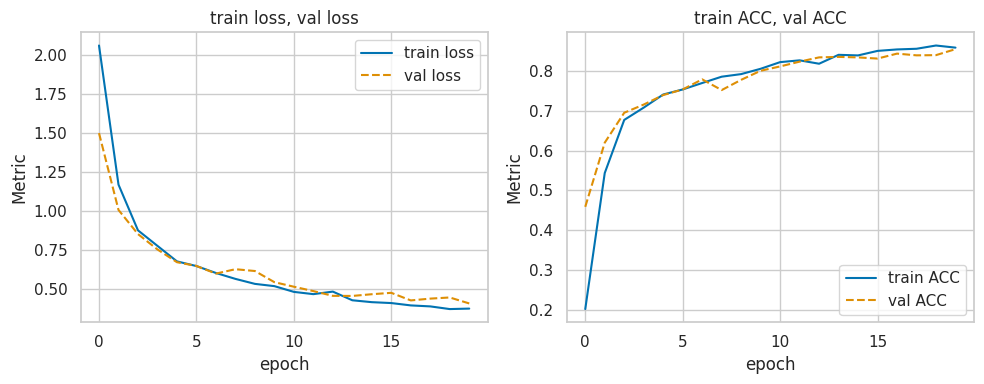

In [15]:
#### Solution

plot_training_metrics(results_FashionMNIST_AdamW_aug,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])


Compare validation loss and accuracy for the three different approaches so far: SGD, AdamW, and AdamW with augmentation.  Make approriate graphs and comment on the three training strategies in terms of their performance on metrics and overfitting.

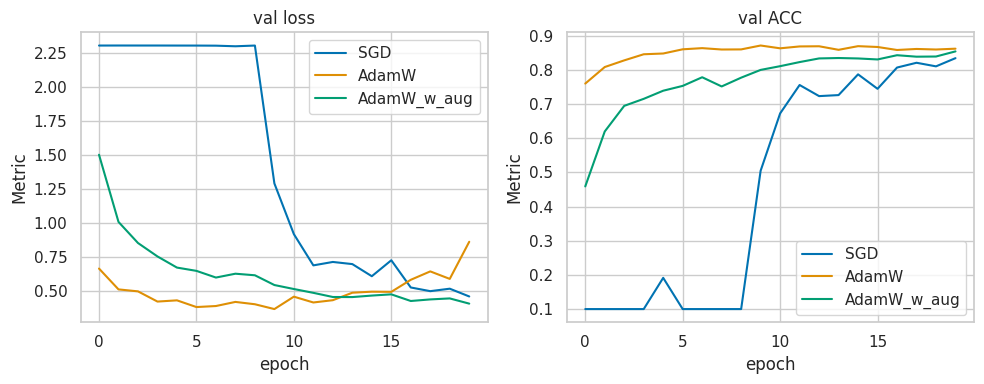

In [17]:
#### Solution
SGD = load_results(MODELS_PATH / 'HW03_FashionMNIST_SGD.pt')
AdamW = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW.pt')
AdamW_aug = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_aug.pt')


plot_training_metrics([SGD, AdamW, AdamW_aug], [['val loss'], ['val ACC']],df_labels=['SGD','AdamW', 'AdamW_w_aug'])

#### Solution
The stochastic gradient descent model required a high learning rate and showed inconsistent performance across multiple trainings. It tended to plateau after about 10 epochs, but the plateau was irregular due to the high learning rate, and the achieved accuracy was lower than that of the other approaches. There was little sign of overfitting.

In contrast, the AdamW model quickly converged to an accuracy plateau—the highest among the three models—by the 10th epoch, although overfitting began to appear after the 4th epoch.

Meanwhile, the AdamW model with augmentation took roughly 30 epochs to converge. It required significantly more time to reach an accuracy comparable to the standard AdamW model, but it exhibited much less overfitting.


## Early Stopping (5 pts)

Early stopping isn't really necessary unless the metrics on the validation or test set start to degrade.  Try it anyway just to reenforce how it works.  In this section implement early stopping based on the validation loss.  Use AdamW and data augmentation.  Add a comparison plot of the two methods.  Comment on the performance with and without early stopping.  Do you get comparable performance?  Add cells in this section as needed.

In [18]:
#### Solution

model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW_stop.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW_stop = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    early_stop_metric= 'loss',
                                    pretend_train=False)



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Early stopping at epoch 16


In [20]:
#### Solution

model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW_aug_stop.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW_4 = train_network(model,
                                    loss_func,
                                    train_loader_aug,
                                    device=device,
                                    val_loader=test_loader_aug,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    early_stop_metric= 'loss',
                                    resume_checkpoint=True)



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Early stopping at epoch 35


In [ ]:
#### Solution
AdamW_stop = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_stop.pt')
AdamW_aug_stop = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_aug_stop.pt')


plot_training_metrics([AdamW_stop, AdamW_aug_stop], [['val loss'], ['val ACC']],df_labels=['AdamW', 'AdamW_w_aug'])

#### Solution
These results closely mirror those from the previous experiment. The model without augmentation stopped at epoch 16, having quickly converged to a stable accuracy—making further training unlikely to yield significant gains. In contrast, the model with augmentation continued until epoch 35, taking considerably longer to both converge and reach its lowest validation error.

## OneCycleLR (5 pts)

Create a new instance of the model.  Implement a OneCycleLR learning rate scheduler and add it your AdamW approach with data augmentation.
You should be able to use a larger max learning rate of 0.003 or so.  Experiment a little to see if you can get similar results to the above with few epochs (you may not be able to).

In [21]:
#### Solution


model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW_OCLR.pt'
epochs = 20
max_lr = 0.003
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW_OCLR = train_network(model,
                                    loss_func,
                                    train_loader_aug,
                                    device=device,
                                    val_loader=test_loader_aug,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    lr_schedule = scheduler,
                                    scheduler_step_per_batch=True,
                                    pretend_train=False)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Load the checkpoint file and make graphs showing the training and validation losses and accuracies.

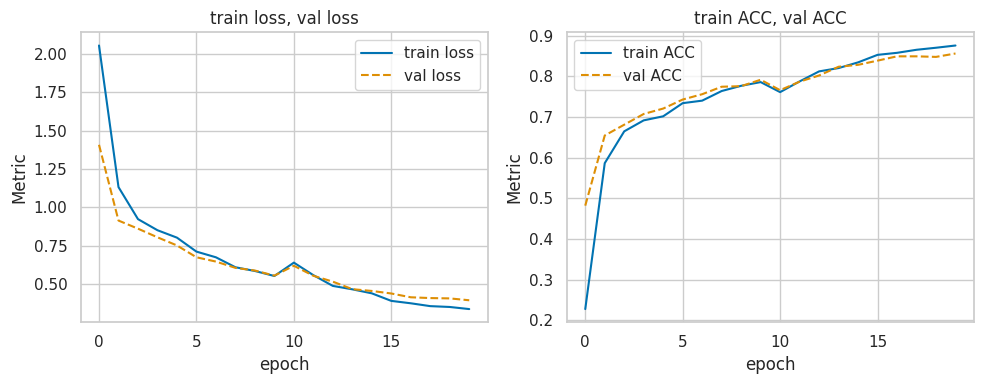

In [22]:
#### Solution
plot_training_metrics(results_FashionMNIST_AdamW_OCLR,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])


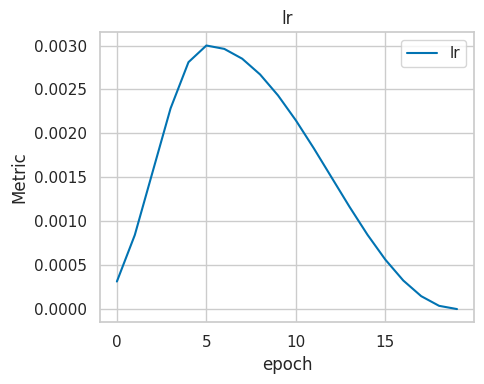

In [23]:
plot_training_metrics(results_FashionMNIST_AdamW_OCLR, [['lr']])

Make a plot comparing the validation losses and accuracies for all of the training approaches above (there should be 4).

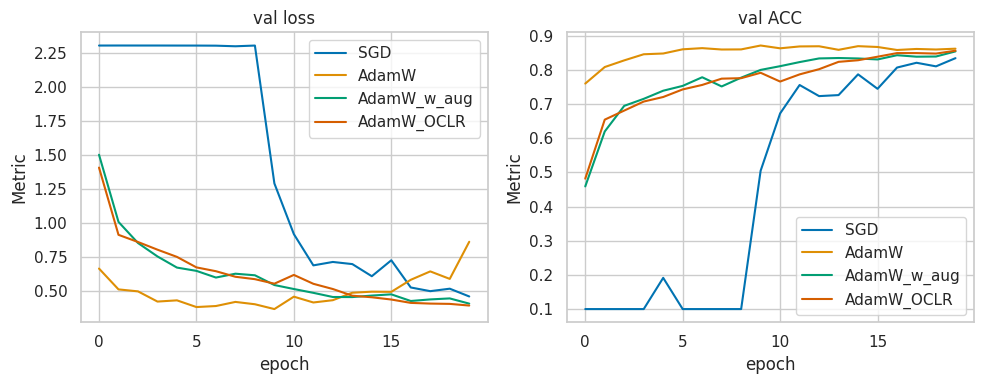

In [ ]:
#### Solution
SGD = load_results(MODELS_PATH / 'HW03_FashionMNIST_SGD.pt')
AdamW = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW.pt')
AdamW_aug = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_aug.pt')
AdamW_OCLR = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_OCLR.pt')


plot_training_metrics([SGD, AdamW, AdamW_aug, AdamW_OCLR], [['val loss'], ['val ACC']],df_labels=['SGD','AdamW', 'AdamW_w_aug', 'AdamW_OCLR'])

Which approach works best?   Why?  

#### Solution

All models using AdamW optimization consistently produced similar accuracies, whereas the SGD model converged to a lower accuracy and showed inconsistency. The AdamW model without data augmentation experienced overfitting, which was mitigated by training with augmented data. This outcome is logical since small, random, artificial changes in the dataset can help prevent the model from overfitting to minor, random features present in the training set. Additionally, models trained with augmented data performed similarly regardless of whether a rate scheduler was used. This also makes sense, as both augmentation and rate scheduling are techniques used to reduce overfitting. Since augmentation largely prevented overfitting, adding rate scheduling on top of that had little further effect. I also tested using a scheduler on data without augmentation and found that overfitting was reduced compared to the AdamW model without a scheduler and without augmentation, although it was still not as effective as using AdamW with augmented data.


## Use best approach on full dataset (5 pts)

Take your best approach and apply it to the full dataset.  (Don't downsample)

This will take a little more than a minute per epoch so run your experiments with the smaller dataset above, then run this once.  You can use `resume_from_checkpoint = True` if you want to extend the training.

How does this compare to the performance you achieved in HW 2.  Import your best run from HW 2 and make a plot comparing the performance of your best approach from this assignment to the approach from the second assignment.  You might need to quickly retrain your HW2 model using the val_loader instead of the test_loader in train_network.

Add code and markdown cells below as needed. 


In [ ]:
# full dataset, no augmentation

# load data
train_dataset_full = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)

# data loaders
train_loader_full = DataLoader(dataset=train_dataset_full, batch_size=64, shuffle=True)

In [ ]:
# full dataset with augmentation

# load data
train_dataset_aug_full = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform_aug)

# data loaders
train_loader_aug_full = DataLoader(dataset=train_dataset_aug_full, batch_size=64, shuffle=True)


In [39]:
#### Solution

# Using AdamW with augmented data, scheduler, and monitoring for loss
model = CNN_model()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW03_FashionMNIST_AdamW_full.pt'
epochs = 30
max_lr = 0.003
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_AdamW_full = train_network(model,
                                    loss_func,
                                    train_loader_aug_full,
                                    device=device,
                                    val_loader=test_loader_aug,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    lr_schedule = scheduler,
                                    scheduler_step_per_batch=True,
                                    early_stop_metric= 'loss',
                                    pretend_train=False)


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

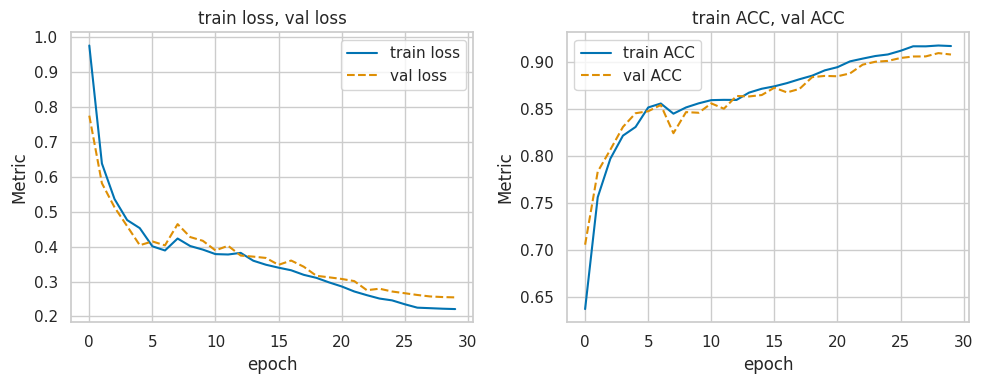

In [40]:
plot_training_metrics(results_FashionMNIST_AdamW_full,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])


In [48]:
#### Solution

# reload train data to get full dataset
mean = (0.2860,)
std = (0.3530,)
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean,std),
])
train_dataset = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


# HW2 solution
class LeNet5Rev_NK_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),  # 14*14 -> 14*14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14 -> 7*7
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0),   # 7*7->3*3
            nn.ReLU(),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*3*3, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))
    

model = LeNet5Rev_NK_3()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3.pt'
epochs = 30 # trained for 30 to match new model. In HW2 I stopped at 5

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_3 = train_network(model,
                                    loss_func,
                                    train_loader_full,
                                    device=device,
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)
    


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

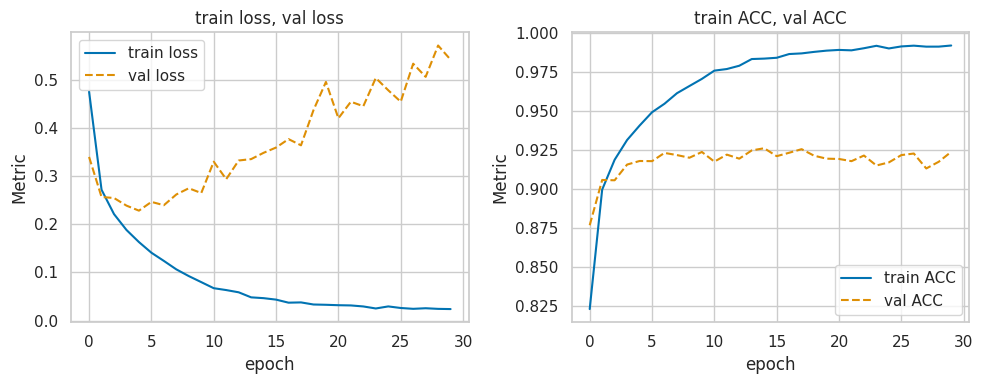

In [42]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_3,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])

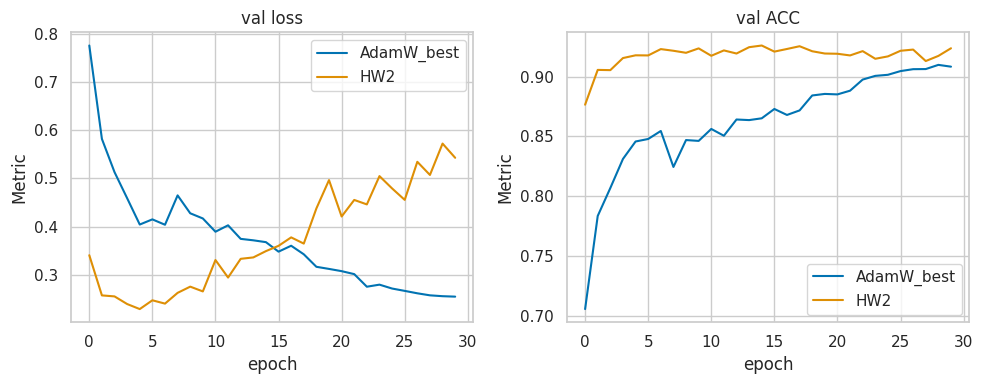

In [43]:
#### Solution
AdamW_full = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_full.pt')
hw2 = load_results(MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3.pt')


plot_training_metrics([AdamW_full, hw2], [['val loss'], ['val ACC']],df_labels=['AdamW_best', 'HW2'])

The HW2 model achieved slightly higher validation accuracy, converging around 0.92 compared to approximately 0.90 for the best AdamW model. However, the best AdamW model exhibited significantly reduced overfitting. In HW2, the training was stopped after just 5 epochs to minimize overfitting. Here, I let the training continue for 30 epochs to compare to the AdamW model. It is very aparent that using these training methods has greated a more robust, better model. 

As an additional experiment, this is "my" model trained with the augmented data and a scheduler.

In [ ]:
model = LeNet5Rev_NK_3()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3_aug.pt'
epochs = 30
max_lr = 0.003
scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_3_aug = train_network(model,
                                    loss_func,
                                    train_loader_aug_full,
                                    device=device,
                                    val_loader=test_loader_aug,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    lr_schedule = scheduler,
                                    scheduler_step_per_batch=True,
                                    early_stop_metric= 'loss',)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

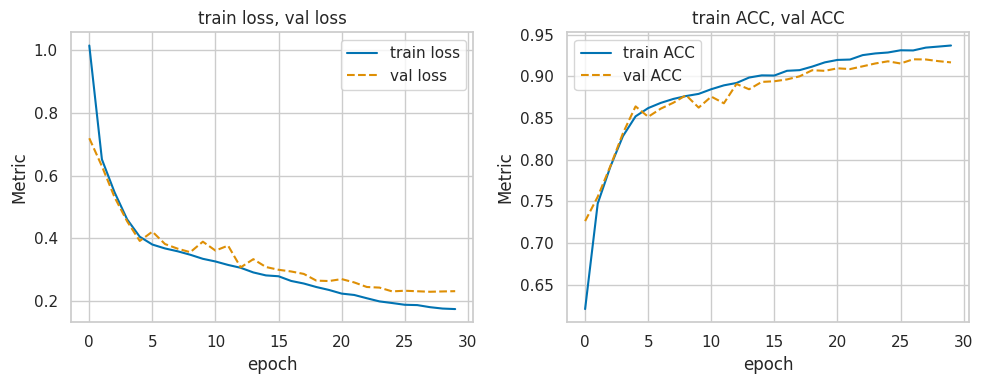

In [46]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_3_aug,  [['train loss', 'val loss'], ['train ACC', 'val ACC']])

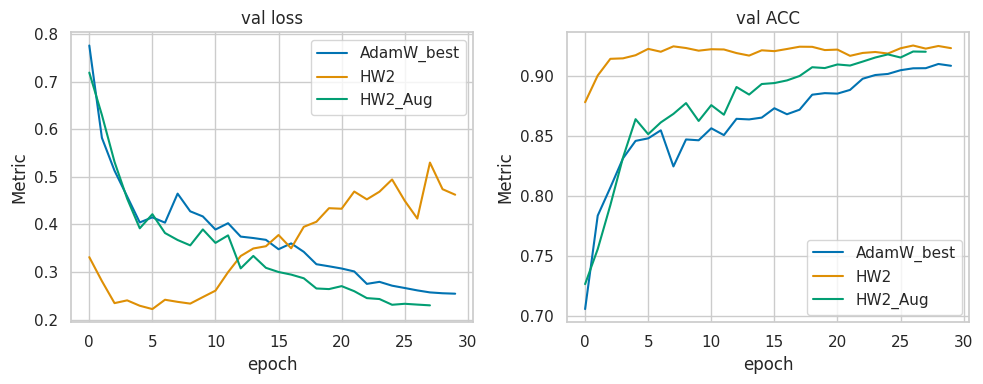

In [49]:
AdamW_full = load_results(MODELS_PATH / 'HW03_FashionMNIST_AdamW_full.pt')
hw2 = load_results(MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3.pt')
hw2_aug = load_results(MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_3_aug.pt')


plot_training_metrics([AdamW_full, hw2, hw2_aug], [['val loss'], ['val ACC']],df_labels=['AdamW_best', 'HW2', 'HW2_Aug'])

Training the HW2 model with augmented data produced interesting results. It converged to a similar accuracy as the non-augmented HW2 model but exhibited considerably less overfitting. Although it appears to have slightly more overfitting than the model used in this homework, it's very encouraging to see the impact data augmentation can have in reducing overfitting.